### Установить Detectron2

In [ ]:
!pip install torch torchvision

In [22]:
!pip uninstall numpy
!pip install numpy==1.26.4n

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /Users/veganhigh/Code/_Study/Computer Vision/OTUS - Computer Vision/0.0 - Проектная работа/instance segmentation/venv-instance-segmentation-detectron2/bin/f2py
    /Users/veganhigh/Code/_Study/Computer Vision/OTUS - Computer Vision/0.0 - Проектная работа/instance segmentation/venv-instance-segmentation-detectron2/lib/python3.11/site-packages/numpy-1.26.4.dist-info/*
    /Users/veganhigh/Code/_Study/Computer Vision/OTUS - Computer Vision/0.0 - Проектная работа/instance segmentation/venv-instance-segmentation-detectron2/lib/python3.11/site-packages/numpy/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [1]:
import torch
import torchvision

In [ ]:
!python3 -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
# если возникают ошибки типа "не найден torch" - обновить wheel и setuptools
# !pip install --upgrade pip setuptools wheel

### Импорты

In [2]:
import numpy as np
print(torch.__version__, torch.cuda.is_available())
print(f"NP {np.__version__}")
# print(detectron2.__version__)

2.2.2 False
NP 1.26.4


In [4]:

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# chatGPT
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_train_loader, build_detection_test_loader

### Utils

In [9]:
def display_images_side_by_side(images, titles=None, max_images_per_row=4):
    num_images = len(images)
    
    if num_images == 0:
        print("Нет изображений для отображения.")
        return
    
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # округление вверх
    num_cols = min(num_images, max_images_per_row)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    if num_rows == 1:
        axes = np.array([axes])
    if num_cols == 1:
        axes = np.array([[ax] for ax in axes])
    
    axes = axes.reshape(num_rows, num_cols)
    
    for i, (ax, image) in enumerate(zip(axes.flat, images)):
        if image.ndim == 2:  # grayscale image
            ax.imshow(image, cmap='gray')
        else:  # RGB image
            ax.imshow(image)
        ax.axis('off')
        if titles is not None and i < len(titles):
            ax.set_title(titles[i])
    
    # Удаление лишних осей
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes.flat[j])
    
    plt.tight_layout()
    plt.show()

### Detectron

In [7]:
dataset_path = "../datasets/instance_segmentation_basil"
# Регистрация тренировочного и тестового датасета
register_coco_instances("my_dataset_train", {}, f"{dataset_path}/train/coco_train.json", f"{dataset_path}/train/images")
register_coco_instances("my_dataset_test", {}, f"{dataset_path}/test/coco_test.json", f"{dataset_path}/test/images")

In [8]:
# Метаданные датасета
train_metadata = MetadataCatalog.get("my_dataset_train")
test_metadata = MetadataCatalog.get("my_dataset_test")

[08/14 04:41:09 d2.data.datasets.coco]: Loaded 50 images in COCO format from ../datasets/instance_segmentation_basil/train/coco_train.json


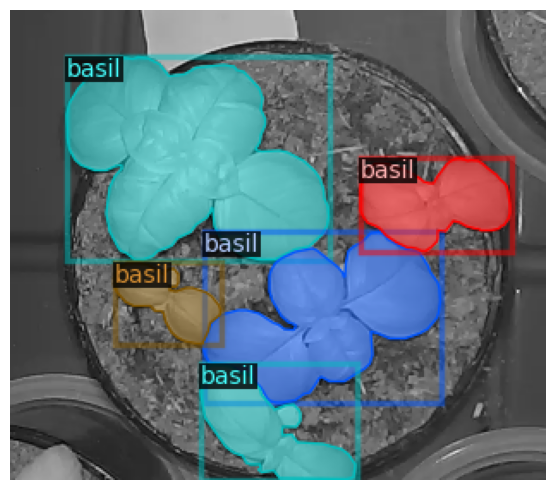

In [13]:
# Пример визуализации данных из тренировочного датасета
dataset_dicts = DatasetCatalog.get("my_dataset_train")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    image = vis.get_image()[:, :, ::-1]
    # cv2.imshow("Sample Image", vis.get_image()[:, :, ::-1])
    display_images_side_by_side([image])

### Обучение!

In [14]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # инициализация весов
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # базовый learning rate
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.MAX_ITER = 1000    # количество итераций тренировки
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # уменьшено по умолчанию
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # установите количество классов в вашем датасете

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

AssertionError: Torch not compiled with CUDA enabled

## Инференс и оценка обученной модели
Теперь можно протестировать обученную модель на валидационном сете "balloon". Сперва создадим предиктор для только что обученной модели:

In [ ]:
# Создание предиктора
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # настройка порога предсказания
predictor = DefaultPredictor(cfg)

In [ ]:
dataset_dicts = DatasetCatalog.get("my_dataset_test")
pred_images = []
for d in random.sample(dataset_dicts, 3):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=test_metadata, scale=0.5)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    pred_images.append(v.get_image()[:, :, ::-1])
display_images_side_by_side(pred_images)

In [ ]:
# Оценка модели на тестовом наборе данных
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))